In [26]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 22,'legend.fontsize':20})
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
from matplotlib.ticker import ScalarFormatter
class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.1f"  # Give format here

In [12]:
import numpy as np
from config import get_from_config
from wiggler_radiation.Wigrad.wigrad_generator import get_rad_mesh_tuple
from wigrad import Wiggler, WigglerRadiationSimulator
from wiggler_radiation.transmission_data import photodiode_quantum_efficiency
config_style_mesh = [
        [
            -0.0254,
            0.0254,
            512
        ],
        [
            -0.0254,
            0.0254,
            512
        ],
        [
            0.4,
            1.8,
            300
        ]
    ]
wiggler = Wiggler(K_peak=get_from_config("K_peak"))
rad_mesh_tuple = get_rad_mesh_tuple(config_style_mesh=config_style_mesh) 
x1d, y1d, l1d = rad_mesh_tuple
nx, ny, nl = [len(v) for v in rad_mesh_tuple]
def get_step(arr):
    return (arr[-1]-arr[0])/(len(arr)-1)
dx, dy, dl = [get_step(v) for v in rad_mesh_tuple]
mesh = (rad_mesh_tuple[0][int(len(rad_mesh_tuple[0])/2):],
        rad_mesh_tuple[1][int(len(rad_mesh_tuple[1])/2):],
        rad_mesh_tuple[2])
spectral_transmission = photodiode_quantum_efficiency(mesh[2])
wr_sim = WigglerRadiationSimulator(
    wiggler,
    mesh,
    gamma=get_from_config("gamma"),
    harmonics=[1, 2,3,4],
    aperture='ellipse',
    # if False, then both polarizations are calculated separately
    only_calc_sum_of_both_polarizations=True,
    spectral_transmission=None
)
wr_sim.calc_photon_flux_on_meshgrid()
wr_sim.extend_results_using_symmetries()

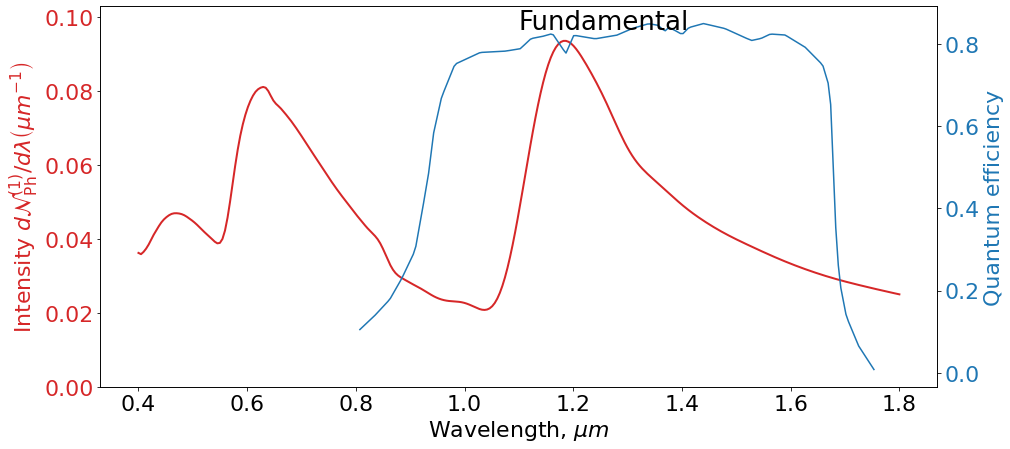

In [24]:
fig,ax = plt.subplots(figsize=[15,7])
ax.set_xlabel('Wavelength, $\mu m$')
color = 'tab:red'
sd = wr_sim.get_spectral_distribution()
plt.plot(l1d, sd, linewidth=2,color = color)
ax.set_ylabel(r'Intensity $d\mathcal{N}^{(1)}_{\mathrm{Ph}}/d\lambda \left(\mu m^{-1}\right)$', color=color)
plt.tick_params(axis ='y',labelcolor=color)
# yfmt = ScalarFormatterForceFormat()
# yfmt.set_powerlimits((0,0))
# ax.yaxis.set_major_formatter(yfmt)  
plt.ylim(0,1.1*max(sd))
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'Quantum efficiency', color=color)  # we already handled the x-label with ax1
ax2.plot(
    l1d,
    np.where(spectral_transmission>0, spectral_transmission, np.nan),
    color=color)
# ax2.plot(wmin_plt,qe_int(wmin_plt),linestyle='--',color=color)
# ax2.plot(wmax_plt,qe_int(wmax_plt),linestyle='--',color=color)
ax2.tick_params(axis='y', labelcolor=color)
align_yaxis(ax, 0, ax2, 0)
plt.text(0.5,0.94,'Fundamental',fontsize=26,transform=ax.transAxes)
plt.savefig('/home/ilobach/PRAB_fluctuations_theory/images/iota_spectrum.png',bbox_inches='tight',dpi=300)
plt.show()

In [14]:
i3d = spectral_transmission[:, None, None]*wr_sim.get_photon_flux_3D()
tot = dx*dy*dl*np.sum(i3d)
x1_2D, x2_2D = np.meshgrid(x1d, x1d)
x1m2_2d = x1_2D-x2_2D
y1_2D, y2_2D = np.meshgrid(y1d, y1d)
y1m2_2d = y1_2D-y2_2D

In [15]:
def get_Mxy(sx, sy):
    res = 0
    for slice2d, lmda in zip(i3d, l1d):
        Eexpx = np.tensordot(slice2d, lmda*np.exp(-(sx*2*np.pi/lmda*x1m2_2d)**2), (1,0))
        Eexpy = np.tensordot(slice2d, lmda*np.exp(-(sy*2*np.pi/lmda*y1m2_2d)**2), (0,1))
        res += np.tensordot(Eexpx, Eexpy.T)
    return tot**2/(dx*dy*dx*dy*dl*1/(2*np.sqrt(np.pi)*1e4)*res)

In [25]:
sx,sy = 815, 75
sz = 38
M = sz*get_Mxy(sx, sy)
print(f"{M:.1e}")

1.2e+07


In [20]:
ibeam = 1.3  # mA
N_av = tot*ibeam*get_from_config("IOTA_revolution_period")/1000/get_from_config("e")
print(f"{N_av:.1e}")

3.3e+07
